# 9. Transformer가 나오기까지
## 9.1 들어가며
### 학습 목표
1. 트랜스포머 이전의 Attention 기법에 대해 간단하게 복습한다.
2. 트랜스포머에 포함된 모듈들을 심층적으로 이해한다.
3. 트랜스포머를 발전시키기 위해 적용된 여러 테크닉들을 알아본다.

## 9.2 Attention의 역사
### Sequence-to-sequence(Seq2seq)
두 개의 RNN을 결합한 Encoder-Decoder 구조를 만들어 문맥 전체를 반영한 번역을 가능하게 했다. 

```python
Before)
Step 1: [나는] -> [I]
Step 2: [나는] [점심을] -> [I] [lunch]
Step 3: [나는] [점심을] [먹는다] -> [I] [lunch] [eat(?)]

After)
Encode(나는 점심을 먹는다)
-> 고정된 크기의 컨텍스트 벡터
-> Decode(컨텍스트 벡터) = I eat lunch!
```

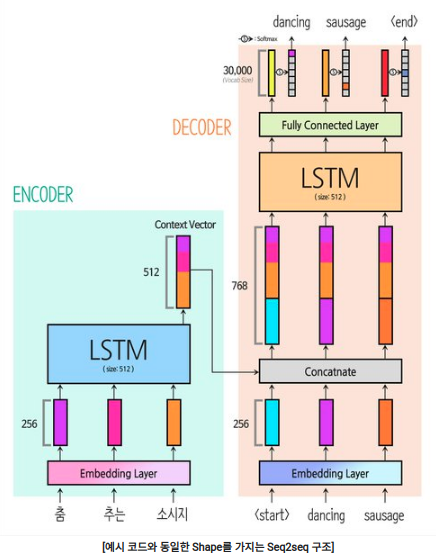

- Seq2Seq의 구조 및 작동 원리 
단순 RNN은 긴 입력에 대한 정보를 학습시키기 어려우므로 Seq2Seq에서는 LSTM을 사용한 Encoder-Decoder 구조를 채택했다. Encoder에 Input Sequence x를 넣으면 고정된 크기의 Representation Vector v(컨텍스트 벡터(context vector))에 모든 정보를 담아 Decoder에게 전달해 주는 구조. Decoder는 전달받은 v를 기반으로 Output Sequence y를 생성한다. 

- Seq2Seq의 문제점     
고정된 크기의 컨텍스트 벡터를 사용하는 것은 정보의 손실을 야기한다. 특히 문장이 길어지면 더더욱 손실이 커진다. 

### Bahdanau Attention(Global Attention)
번역하는 데에 중요한 단어만 큰 비중을 줘서 성능을 높여보자며 Dzmitry Bahdanau가 Attention을 제안했다.

[Attn: Illustrated Attention](https://eda-ai-lab.tistory.com/157): Bahdanau Attention의 멋진 시각화

- 다시 정리(L4에도 정리되어 있음)    
디코더에서 문장을 생성할 때 입력된 문장의 유용한 부분에 집중하여 긴 입력 문장에 효과적으로 대처할 수 있다. 각 단어에 점수를 할당해 다른 단어에 초점을 맞추고, softmaxed 점수를 사용해 인코더의 hidden state 가중합을 구해 context 벡터를 얻는다. 

![](https://images.velog.io/images/guide333/post/cd7b5f8b-843d-4420-b8e6-7641f32696fd/Screenshot%20from%202021-04-19%2013-09-31.png)

디코더와 인코더의 hidden state 사이의 평가 점수(특정 벡터 공간으로 매핑된 두 hidden state의 합)를 통해 1) 모든 hidden state의 점수를 얻고(여기서 높은 점수를 얻은 단어에 초점을 맞춤, 변환된 단어가 이 인코더의 hidden state에 영향을 크게 받을 것을 의미함.) 2) 모든 점수를 softmax 레이어를 통과시킨다. (0-1사이의 소수값, 확률) 3) 각 인토더의 hidden state에 softmaxed 점수를 곱해 얼라인먼트 벡터(annotation 벡터)를 얻는다. 4) 얼라인먼트 벡터는 합쳐져 context 벡터를 생성한다. 5) 컨텍스트 벡터가 디코더에 전달된다. (아래의 그림)


![](https://images.velog.io/images/guide333/post/2e297773-3f25-4025-b333-824a2c815c4e/Screenshot%20from%202021-04-15%2016-45-34.png)

매 스텝의 Hidden State 값을 사용하는 것은 효과가 좋았고, 만들어진 Attention을 히트맵으로 출력하면 의미적으로 유사한 단어들끼리 연결되는 것을 볼 수 있었다. 

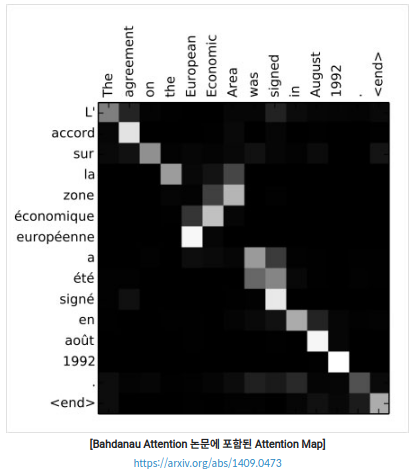

대각선이 역행하는 ```European Economic Area``` 부분을 유심히 보시면 같은 의미의 불어 ```zone economique europeenne```과 의미적으로 유사한 것들끼리 연결된 것을 볼 수 있다.

- Bahdanau Attention의 문제점     
T 스텝에서 Decoder의 Hidden State를 구하기 위해 T-1 스텝의 Hidden State를 사용해야 한다는 것. 이는 재귀적으로 동작하는 RNN에 역행하는 연산이므로 효율적이지 못하다. 

### Luong Attention(Local Attention)

[[Attention] Luong Attention 개념 정리](https://hcnoh.github.io/2019-01-01-luong-attention)

- 다시 정리(L4에도 정리되어 있음)

[Bahdanau Attention]
![](https://images.velog.io/images/guide333/post/e6f8c119-bd48-443a-8d96-b953a7a9d443/Screenshot%20from%202021-04-15%2017-14-27.png)

[Luong Attention]
![](https://images.velog.io/images/guide333/post/2a5bca1f-4c77-41e6-b6be-1065e07dc212/Screenshot%20from%202021-04-15%2017-14-35.png)

hidden state vector $s_t$는 RNN의 hidden state 역할만 하고, 출력 $\hat y_t$를 구할 때는 새로운 $\bar s_t$를 거친다. 출력 $\hat y_t$를 구하는 부분과 RNN의 재귀 연산이 수행되는 부분이 분리되기 때문에 computation path가 간소화된다. 

## 9-3. Attention Is All You Need!
2017년, [\<Attention Is All You Need>](https://arxiv.org/pdf/1706.03762.pdf) 라는 충격적인 제목의 논문이 등장했다.
    
>We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely.
(우리는 __RNN과 CNN을 완전히 배제__ 하고 __Attention 메커니즘에만 기반__ 을 둔 새롭고 단순한 구조, Transformer를 제안합니다.)*

### Transformer
__기울기 소실(Vanishing Gradient)를 해결__ 하고, 순차적으로 계산하기 때문에 __병렬 처리가 불가능하다는 문제를 해결__ 하기 위해 __RNN과 CNN을 완전히 배재__ 했다. 

__문장에서 연속성이라는 개념을 배제__ 하였고, __Attention으로 각 단어들의 상관관계를 구하는데 집중__ 하였다. 즉 입력된 문장의 순서를 고려하지 않는다. 

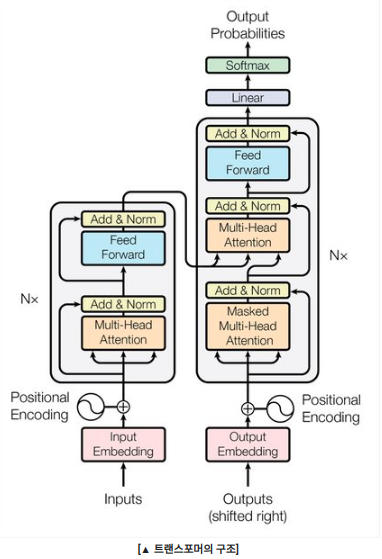

- Transformer의 구조    
Encoder-Decoder 구조를 사용, 각 Encoder, Decoder 안에는 다양한 모듈이 들어 있다. 여러 개의 Encoder, Decoder를 각각 쌓아 올린다. (논문에서는 6개 사용) 

stacked self-attention(intra-attention)과 point-wise fc layer들을 사용해서 구성(참고: https://reniew.github.io/43/)

## 9-4. Positional Encoding

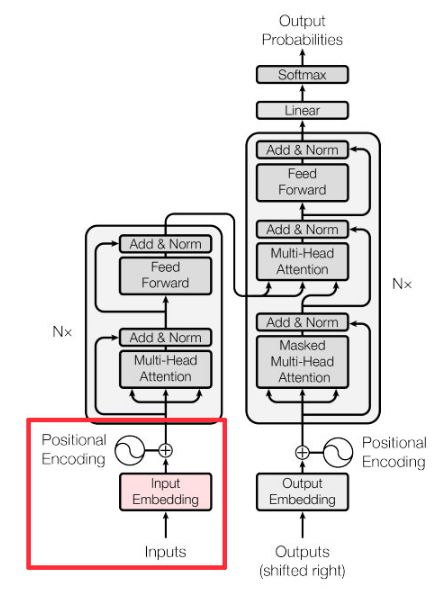

트랜스포머는 RNN/CNN을 배제하였기 때문에 문장의 연속성이 없어서 입력된 단어의 순서를 고려할 수 없다. 따라서 Positional Encoding을 포함하여 __문장에 연속성을 부여__ 하였다. 즉 들어온 순서를 단어에 표기하였다. 예: [빨간 + 1] [사과 + 2] ...

[jeongstudy: positional encoding이란 무엇인가](https://skyjwoo.tistory.com/31)

#### 정리    
attention layer에 들어가기 전 입력값으로 주어질 단어 vector 안에 positional encoding 정보(단어의 위치 정보)를 포함시킨다. 단어의 위치 정보를 부여하는 방법은 2가지가 있다. 

1) 데이터에 0-1 사이의 label을 붙임     
문장의 길이에 따라 더해지는 값이 가변적이다. 따라서 단어 간의 거리(Delta)가 일정하지 않다.

2)각 time-step마다 선형적으로 숫자를 할당하는 방법      
단어 간의 거리(Delta)가 일정해지는 것은 좋지만 범위가 무제한이기 때문에 값이 매우 커질 수 있고 모델이 일반화하기 어려워진다.

이상적인 모델은          
1) 각 time-step(문장에서의 단어 위치)마다 하나의 유일한 encoding 값을 출력    
2) 서로 다른 길이의 문장에서 두 time-step 간 거리가 일정     
3) 모델에 대한 일반화 가능(순서를 나타내는 값이 특정 범위 내에 있어야 함)    
4) 하나의 key 값처럼 결정(항상 같은 값)      
을 만족시켜야 한다. 

### Positional Encoding의 수식 
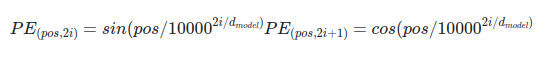

pos: 단어가 위치한 Time-step, i: Encoding 차원의 Index, $d_{model}$: 모델의 Embedding 차원 수  

=> __Sinusoid(사인파) Embedding__

## 9-5. Multi-Head Attention
Positional Embedding이 된 문장에서 Attention을 추출하는 부분

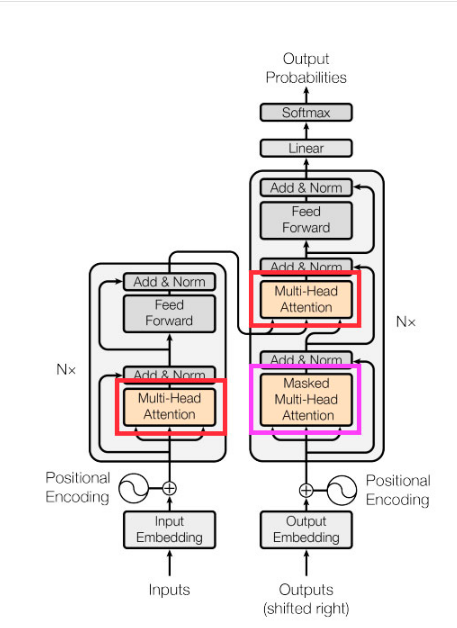

- Masked Multi-Head Attention = Multi-Head Attention + Casualty Masking(인과 관계 마스킹)

### Multi-Head Attention
- Multi-Head Attention = Linear Layer + Scaled Dot-Product Attention

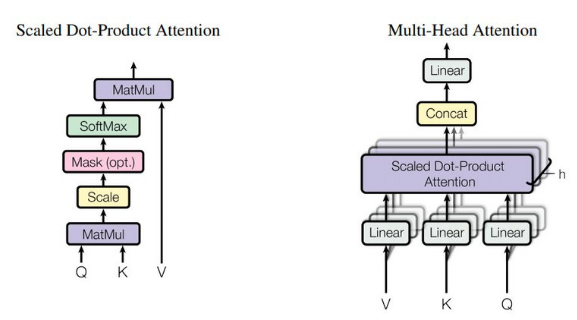

#### Scaled Dot-Product Attention

![](https://images.velog.io/images/guide333/post/77e4c224-bc1a-478c-8483-a5e365f4d243/Screenshot%20from%202021-04-19%2014-49-24.png)

- 오른쪽: 전통적인 Attention         
  - attention: 디코더의 포지션 i에서 바라본 인코더의 context vector $c_i$를 해석하기 위해 인코더의 각 포지션 j에 부여한 가중치, 이 가중치는 디코더의 hidden state $s_i$와 인코더의 hidden state $h_j$ 사이의 유사도를 통해 계산되었다.

- 왼쪽: Scaled Dot-Product Attention    
  - Q(Query): 디코더의 hidden state
  - K(Key): 인코더의 hidden state
  - attention weight: $softmax(\frac {QK^T}{\sqrt d_k})$ (Q와 K의 유사도를 dot product로 계산)
  - attention weight와 V(value)를 곱함(V는 인코더에서 가져옴)
  
- Attention(Q, K, V) $\doteqdot c_i$ 
- $softmax(\frac {QK^T}{\sqrt d_k}) \doteqdot \alpha_{ij}$
  
[Transformer: Attention is all you need](https://reniew.github.io/43/)  
##### 정리   

- Encoder         
6개의 Encoder layer가 반복, 각 layer는 2개의 sub-layer로 구성. multi-head self-attention mechanism + point-wise fc-layer. 각 sub-layer에 residual connection 사용해 layer들을 통과한 결과에 residual 값을 더한 후 layer의 값을 normalize 한다. 모델 전체적으로 residual 계산을 쉽게 하기 위해 output의 dimension은 모두 512.

- Decoder    
6개의 Decoder layer가 반복, 각 layer는 3개의 sub-layer로 구성. masked multi-head self-attention mechanism + multi-head self-attention mechanism(encoder의 결과 포함) + point-wise fc-layer. 각 sub-layer에 residual connection 사용해 layer들을 통과한 결과에 residual 값을 더한 후 layer의 값을 normalize 한다. 

- Scaled dot-product attention
  - 해당 attention의 input: $d_k$ dimension을 가지는 queries, keys, $d_v$ dimension을 가지는 values
  
  $Attention(Q, K, V) = softmax(\frac {QK^T}{\sqrt d_k})V$
  
실제 계산에는 여러 Q, K, V를 행렬로 만들어 계산한다.    

Query가 어떤 단어와 관련되어 있는지 찾기 위해 모든 key들과 연관성을 계산(dot product)한 후, 그 값을 확률값으로 만들어(softmax) 준다. 따라서 query가 어떤 key와 높은 확률로 연관성을 가지는지 알게 된다. 구한 확률값을 value에 곱해서 value에 대해서 scaling한다. 

key와 value는 같은 단어를 의미하나 2개로 나눠 계산하는 이유는 key를 통해 각 단어와의 연관성의 확률을 계산하고 value는 그 확률을 사용해서 attention 값을 계산한다. 

![](https://images.velog.io/images/guide333/post/6141ad25-1edc-4264-ae61-49d2c2fff25f/Screenshot%20from%202021-04-19%2015-16-39.png)

dimension의 루트값으로 나눠주는(rescaling) 이유는 vector가 길어질수록 (dimension이 커질수록) dot-product값이 커지는데, 그 값을 softmax함수에 넣어주면 미분값이 작아진다. back-propagation과정에서 작은 미분값의 의미는 상대적으로 학습이 느려지거나 학습이 잘 안 될 수 있다는 뜻이다. 

-  Scaled Dot-Product Attention은 Dot-Product(=Multiplicative, 곱 연산 기반) Attention을 사용하였고, 차원이 깊어짐에 따라 softmax 값이 작아지는 것을 방지하기 위해 Scale 과정을 포함했다. 

### 인과 관계 마스킹(Causality Masking)
- 참고: Sequence-to-sequence 모델을 훈련할 때에 Decoder의 첫 입력으로 \<start> 토큰과 컨텍스트 벡터로 압축된 입력 문장을 단서로 첫 번째 단어를 생성해야 하고, 그다음 스텝도 같은 단서에 방금 Decoder 본인이 생성한 첫 번째 단어를 포함하여 두 번째 단어를 생성한다. 자기 자신을 입력으로 하여 자기 자신을 예측하는 특성을 자기 회귀(Autoregressive)라 한다. 

트랜스포머는 모든 단어를 병렬적으로 처리하기 때문에 자기 회귀적인 특성을 잃어버렸고, 이는 문장을 생성할 수 없음을 의미한다. 이 자기 회귀적인 특성을 살리기 위해 __인과 관계 마스킹__ 을 추가하였다. 인과 관계 마스킹은 목표하는 문장의 일부를 가려 __인위적으로 연속성을 학습__ 하게 하는 방법이다.

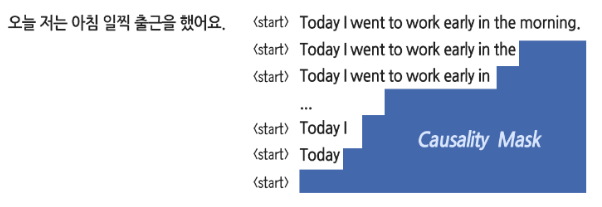

위의 과정을 거치면 __모든 Time-step에 대한 입력을 한 번에 처리__ 하면서 __자기 회귀적인 특성도 유지__ 하게 된다.  테스트 시 소스 문장을 Encoder에 전달하고 타겟 문장을 ```<start>```만 넣어도 모델이 ```<start>``` 토큰만 보고 문장을 생성한 적(위 그림의 마지막 step)이 있기 때문에 첫 번째 단어를 생성할 수 있고 생성된 단어는 입력으로 다시 전달되어 자귀 회귀적으로 문장을 생성한다. 

따라서 인과 관계 마스크는 __대각항을 포함하지 않는 삼각 행렬__ 의 모양을 갖는다. 입력 문장만을 보고 첫 번째 단어를 생성하는 것은 타겟 문장을 모두 가리는 것이 타당하니 대각항을 포함하는 게 맞지만, 그럴 경우 Attention 값을 구하는 과정에서 마지막(혹은 첫 번째) 행이 0개 요소에 대해 Softmax를 취하게 되므로 오류를 야기한다. 따라서 ```<start>``` 토큰을 활용해 마스크가 대각항을 포함하지 않는 형태가 되게 한다. 

(참고) 대각항(diagonal entry)이란 행렬에서 행과 열의 지표수가 같은 성분(대각성분)을 말합니다. 행렬에 대한 개념 복습은 [여기](https://sensol2.tistory.com/26)를 참고


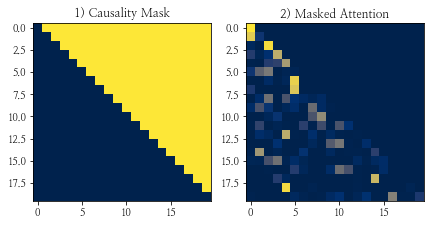

In [4]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def make_dot_product_tensor(shape):
    A = tf.random.uniform(shape, minval=-3, maxval=3.0)
    B = tf.transpose(tf.random.uniform(shape, minval=-3, maxval=3.0), [1, 0])

    return tf.tensordot(A, B, axes=1)

def generate_causality_mask(seq_len):
    # np.cumsum(): 배열에서 행에 따라 누적되는 원소들의 누적합 계산
    # np.eye(): 대각선이 1인 seq_len x seq_len 크기의 대각행렬 생성
    mask = 1 - np.cumsum(np.eye(seq_len, seq_len), 0)
    return mask

sample_tensor = make_dot_product_tensor((20, 512))
sample_tensor = sample_tensor / tf.sqrt(512.)

mask = generate_causality_mask(sample_tensor.shape[0])

fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.set_title('1) Causality Mask')
ax2.set_title('2) Masked Attention')

ax1.imshow((tf.ones(sample_tensor.shape) + mask).numpy(), cmap='cividis')

mask *= -1e9
ax2.imshow(tf.nn.softmax(sample_tensor + mask, axis=-1).numpy(), cmap='cividis')

plt.show()

### Multi-Head Attention
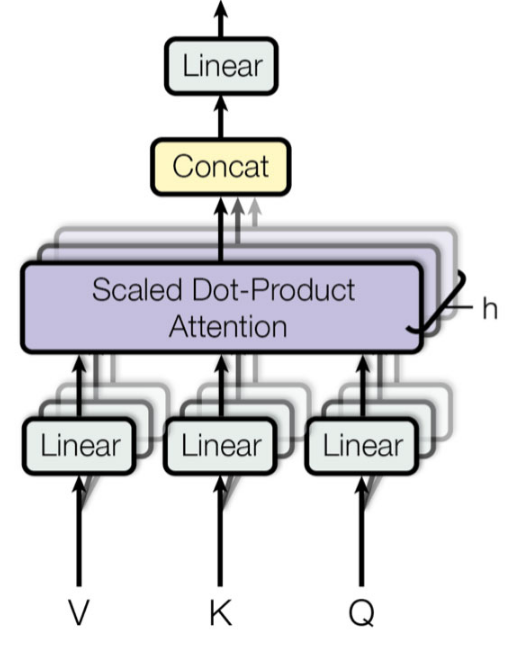

한 단어가 여러 차원의 embedding을 가진다면, 일부의 차원들은 각각 다른 정보를 담고 있을 것이다. 차원마다 가지고 있는 다른 정보를 여러 개의 Head로 나누어 처리하면 Embedding의 다양한 정보를 캐치할 수 있을 것이라는 아이디어로 시작되었다.

![](https://images.velog.io/images/guide333/post/5acc2f39-cb2e-420d-bd57-98d497325cbd/Screenshot%20from%202021-04-19%2015-59-57.png)

Multi-Head Attention에서 __Head는 주로 8개__ 를 사용한다. Embedding된 10개 단어의 문장이 ```[10, 512]```의 형태를 가진다면, Multi-Head Attention은 이를 ```[10, 8, 64]```로 분할하여 연산한다. __각 64차원의 Embedding을 독립적으로 Attention__ 한 후, 이를 __이어붙여__ 다시금 ```[10, 512]```의 형태로 되돌리며 연산은 끝이 난다.

Head로 쪼갠 Embedding들끼리 유사한 특성을 가진다는 보장이 없기 때문에 __앞단에 Linear 레이어를 추가__ 한다. __Linear 레이어는 데이터를 특정 분포로 매핑__ 시키는 역할을 해주기 때문에, 설령 단어들의 분포가 제각각이더라도 Linear 레이어는 Multi-Head Attention이 잘 동작할 수 있는 적합한 공간으로 Embedding을 매핑한다.

마찬가지로 각각의 Head가 Attention 한 값이 균일한 분포를 가질 거란 보장이 없기 때문에 모든 Attention 값을 합쳐준 후, 최종적으로 Linear 레이어를 거치게 된다. 

## 9-6. Position-wise Feed-Forward Networks

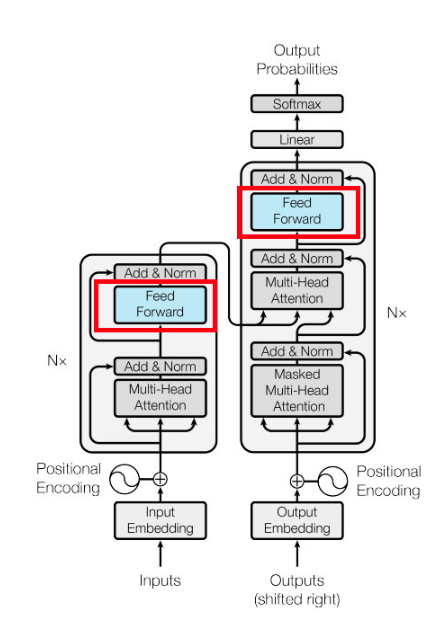

Position-wise Feed-Forward Networks는 크게 다루지 않는 부분이다. 

![](https://images.velog.io/images/guide333/post/22ef0143-035b-4c92-bf1e-8623066a4092/Screenshot%20from%202021-04-19%2016-06-51.png)

Position-wise Feed-Forward Networks는 2개의 Linear 레이어($W_1, W_2$)로 이루어져 있고 두 레이어 사이에 활성화 함수 ReLU가 존재한다. 

W는 Linear 레이어이고, max(0, x) 함수는 활성 함수 ReLU이다. 예를 들면 10단어로 이루어진 Attention된 문장 [10, 512]를 [10, 2048] 공간으로 매핑, 활성함수를 적용한 후 다시 [10, 512] 공간으로 되돌린다. 

- '커널 사이즈가 1인 Convolution을 두 번 연산한 것과 동일하다'는 뜻      
![](https://images.velog.io/images/guide333/post/d4466d87-9ec4-4b07-a745-39c0512ae67c/Screenshot%20from%202021-04-19%2016-12-51.png)

한 단어를 Embedding 차원만큼의 채널을 갖는 이미지라고 생각하자. Convolution 레이어의 Weight는 ```[입력 차원 수 X 출력 차원 수 X 커널의 크기]``` 이므로 커널의 크기가 1이라면 Linear 레이어와 동일한 크기의 Weight를 가진다.

- Evolved Transformer            
최근에는 구글에서 AI를 만드는 AI, AutoML을 활용해 최적의 트랜스포머 구조를 찾아냈다. 진화된 트랜스포머(Evolved Transformer)는 두 층의 레이어 중 아래층 레이어에서 차이를 보이는데, 이때 Linear 레이어를 Convolution 레이어로 표기한다. 

- 참고: [Applying AutoML to Transformer Architectures](https://ai.googleblog.com/2019/06/applying-automl-to-transformer.html)


## 9-7. Additional Techniques
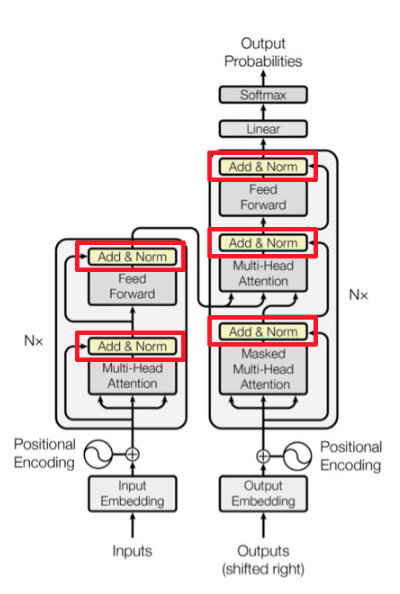

### Layer Normalization
Layer Normalization은 데이터를 Feature 차원에서 정규화를 하는 방법이다. 10단어의 Embedding된 문장 ```[10, 512]```에서 512차원 Feature를 정규화하여 분포를 일정하게 맞춰준다. 

[Introduction to Deep Learning Normalization](https://subinium.github.io/introduction-to-normalization/)

#### 정리
- Normalization(정규화)    
값 범위의 차이를 왜곡시키지 않고 데이터셋을 공통 스케일로 변경하는 것, 데이터 feature의 scale을 직접 조정, feature scaling, Min-Max Scaler, 데이터를 0과 1 사이의 스케일로 조정

$$\frac {x-x_{min}}{x_{max}-x_{min}}$$

- Regularization(일반화)    
모델의 설명도를 유지하면서 모델의 복잡도를 줄이는 방식, Early stopping, Noisy input, drop-out, Pruning & feature selection, emsemble 등 

- Standardization(표준화)    
Standard Scaler 또는 z-score normalization, 기존 데이터를 평균 0, 표준 편차 1인 표준분포의 꼴 데이터로 만드는 것. 평균을 기준으로 얼마나 떨어져 있는지를 살펴볼 때 사용된다. 데이터의 분포가 가우시안 분포를 따를 때 유용하다. 

$$\frac {x-\bar x}{\sigma}$$

- Batch Normalization    
Gradient Vanishing / Gradient Exploding이 일어나지 않도록 하는 방법 중 하나. Training 과정 자체를 안정화해 학습 속도를 가속화한다. mini-batch마다 평균 0, 단위 표준 편차 유지를 시도한다. 1) mini-batch의 평균 구하기 2) mini-batch의 분산과 표준 편차 구하기 3) normalize (엡실론을 제외하면 Standardization) 4) 스케일 조정 및 분포 조정

장점: propagation에서 parameter의 scale 영향을 받지 않으므로, learning rate를 크게 설정 가능. Weight regularization과 Dropout을 제외해 학습 속도 향상, loss surface를 보다 쉽게 찾음, 최적화를 쉽게 만듬

단점: 많은 자원 사용. 모델을 복잡하게 함.

- Batch Normalization의 대안    
![](https://images.velog.io/images/guide333/post/02a8d7e0-2d5d-486f-99e8-2d338c597a4b/Screenshot%20from%202021-04-19%2016-33-19.png)

1. Weight Normalization       
layer의 가중치를 정규화. 

2. Layer Normalization    
BN과 유사한 형태

||BN|LN|
|--|--|--|
|정규화|Batch 차원|Feature 차원|
|계산|batch 전체 계산, 각 batch에서 동일|각 특성에 따라 따로 계산, 독립적 계산|
|사이즈|Batch 사이즈가 작으면 비효율적|batch 사이즈에 무관|

3. Instance Normalization    
LN과 유사하나 평균과 표준 편차를 구해 각 example의 각 채널에 정규화 진행

4. Group Normalization    
IN과 유사, 채널을 그룹으로 묶어 평균과 표준 편차를 구함. 

그 외에도 많음

### Residual Connection
skip Connection, 2015년 ResNet이라는 모델에서 처음 제안.

[(7) ResNet (Residual Connection)](https://itrepo.tistory.com/36)

- Optimization 문제: 네트워크가 깊어질수록 Optimize(train)하는 것이 어려워지므로 Deep Network는 Shallow Network만큼의 성능을 보이지 않는다. 

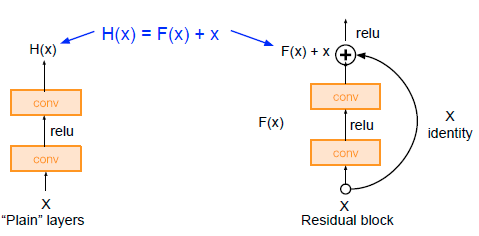

- Residual Connection        
레이어는 연산을 하고 나서 Skip conenction을 통해 각각의 Layer(Block)들이 작은 정보들을 추가적으로 학습하도록 한다. 이는 각각의 레이어가 배워야할 정보량을 축소시킨다. 

수식: y = f(x) + x    
여기서 y는 기존에 학습한 정보를 보존하고, 거기에 추가적으로 학습하는 정보이다. output에 이전 레이어에서 학습했던 정보를 연결함으로써 해당 층에서는 추가적으로 학습해야 할 정보만 mapping학습한다. 

Q10. Residual Block은 굉장히 간단한 수식으로 표현이 가능합니다. 수식을 적어보세요.

[Detailed Guide to Understand and Implement ResNets](https://cv-tricks.com/keras/understand-implement-resnets/): ResNet의 등장 배경


### Learning Rate Schedular
트랜스포머를 훈련할 때 Adam Optimizer를 사용했는데, Learning Rate를 수식에 따라 변화시키며 사용했다. 아래의 수식을 따르면 warmup_steps까지는 lrate가 __선형적으로 증가__하고 이후에는 step_num에 비례해 __점차 감소__한다. 

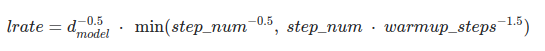

이런 Learning rate를 사용하면 __초반 학습이 잘 되지 않은 상태에서의 학습 효율이 늘어나__ 고, 어느 정도 학습이 된 후에는 __디테일한 튜닝__ 을 통해 Global Minimum을 찾아가는 효과가 나타난다. 학습의 초반과 후반은 warmup-steps 값에 따라 결정된다. 

/home/aiffel-dj44/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in power
  # Remove the CWD from sys.path while we load stuff.


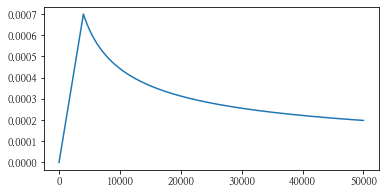

In [5]:
import matplotlib.pyplot as plt
import numpy as np

d_model = 512
warmup_steps = 4000

lrates = []
for step_num in range(0, 50000):
    lrate = (np.power(d_model, -0.5)) * np.min(
        [np.power(step_num, -0.5), step_num * np.power(warmup_steps, -1.5)])
    lrates.append(lrate)

plt.figure(figsize=(6, 3))
plt.plot(lrates)
plt.show()

### Weight Sharing
모델의 일부 레이어가 동일한 사이즈의 weight를 가질 때 등장하는 테크닉. 하나의 Weight를 두 개 이상의 레이어가 동시에 사용하는 것.  

- 예: 언어 모델의 Embedding 레이어와 최종 Linear 레이어가 동일한 사이즈의 Weight를 가진다. 프로그래밍 개념 중 Call By Reference(참조에 의한 호출: 인자로 받은 값의 주소를 참조하여 직접 값에 영향을 준다.)

Weight Sharing은 튜닝해야 할 파라미터 수가 감소하기 때문에 학습에 더 유리, 자체 Regularization 효과. (유연성이 제한되어 과적합을 피하기 용이)

트랜스포머에서는 __Decoder의 Embedding 레이어와 출력층 Linear 레이어의 Weight를 공유__ 하는 방식을 사용한다. 소스 Embedding과 타겟 Embedding도 논문상에서는 공유했지만 이는 언어의 유사성에 따라서 선택적으로 사용한다. 만일 소스와 타겟 Embedding 층까지 공유한다면 3개의 레이어가 동일한 Weight를 사용한다. 

또한 출력층 Linear 레이어와 Embedding 레이어의 Feature 분포가 다르므로 Embedding 된 값에 d_model의 제곱근 값을 곱해준다. 분포를 맞춰줌과 동시에 Positional Encoding이 Embedding 값에 큰 영향을 미치는 것을 방지한다. 

## 9-8. 트랜스포머, 그 후엔
### BERT, GPT
[BERT, GPT](https://ratsgo.github.io/nlpbook/docs/language_model/bert_gpt/#gpt)

#### 정리
[pre-trained]
![](https://images.velog.io/images/guide333/post/d65bd259-1599-42fb-8003-7988081ee9c7/Screenshot%20from%202021-04-19%2019-10-42.png)

- GPT(Generative Pre-trained Transformer)    
언어 모델, 이전 단어가 주어졌을 때 다음 단어가 무엇인지 맞추는 과정에서 프리트레인한다. 문자 시작부터 순차적으로 계산하므로 __일방향 어텐션__ 사용, __문장 생성__ 에 강점. __트랜스포머의 디코더__ 만 사용맞추려 하는 단어 이전 단어들만 참조할 수 있다. 정답 단어 이전 단어에 대응하는 GPT 마지막 레이어의 출력 결과에 어떤 계산을 수행해, 학습 대상 언어의 어휘 수만큼의 확률 벡터가 되게 한다. 이번 시점의 정답에 해당하는 확률은 높이고 나머지 단어의 확률이 낮아지도록 모델 전체를 업데이트한다. 다음 단어에도 이 과정을 반복한다. 

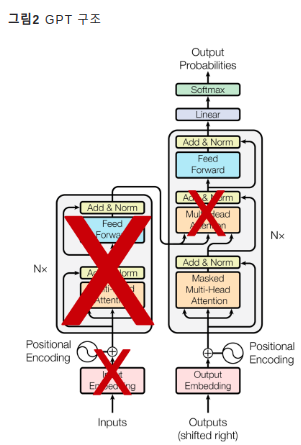

- BERT(Bidirectional Encoder Representations from Transformers)    
마스크 언어 모델, 문장 중간에 빈칸을 만들고 해당 빈칸의 단어를 맞추는 과정에서 프리트레인한다. 빈칸(마스크 토큰) 앞뒤 문맥을 모두 살피므로 __양방향 어텐션__ 사용. __문장의 의미 추출__ 에 강점, __트랜스포머의 인코더만__ 사용. 마스크 단어(맞춰야 하는 단어)에 대응하는 BERT 마지막 레이어의 출력 결과에 어떤 계산을 수행해 학습 대상 언어의 어휘 수만큼의 확률 벡터가 되도록 한다. 정답에 해당하는 확률은 높이고 나머지 단어의 확률이 낮아지도록 모델 전체를 업데이트한다. 

![](https://images.velog.io/images/guide333/post/bfd66bcd-ed68-4d59-ac98-66345b62a801/Screenshot%20from%202021-04-19%2019-18-03.png)

트랜스포머는 __max_sequence_length를 512에서 1024 정도로만 사용__ 한다. 그래서 초기에는 주로 몇개 문장 단위의 번역 작업에 활용되었다. __문단의 문맥을 파악++ 하는 수준까지의 보다 긴 입력 길이를 처리할 수 있도록, 기존의 트랜스포머에 Recurrence라는 개념을 추가한 Transformer-XL이 제안되기도 했다. 

[Transformer-XL 자료정리 및 설명요약](https://comeng.tistory.com/entry/Transformer-XL-%EC%9E%90%EB%A3%8C%EC%A0%95%EB%A6%AC-%EB%B0%8F-%EC%84%A4%EB%AA%85%EC%9A%94%EC%95%BD)


연산량을 줄이고자 하는 연구가 늘고 있다. __Reformer__ 는 트랜스포머를 연산량 측면에서 혁신적으로 개선한 모델이다. 

[Reformer:효율적인 트랜스포머](https://brunch.co.kr/@synabreu/31)

- "Multi-Head Attention에서 모든 Head가 과연 필요한가?" (여기부터 보지 않았음)

[월간 자연어 처리 - MHA](https://www.facebook.com/permalink.php?story_fbid=156092245822648&id=111809756917564)

[(논문리뷰) Are Sixteen Heads Really Better than One?](https://littlefoxdiary.tistory.com/m/66?category=847374)

대다수의 attention head는 예측 시 제거해도 성능에 영향이 없거나 성능이 향상되기도 했다. 즉 테스트 시 대부분의 head는 나머지 모델이 주는 정보와 중복되는 정보를 제공한다. 테스트 시에는 대부분의 레이어에서 하나의 head로 충분했다. (파라미터는 크게 감소) 그리디 알고리즘을 사옹해 모델을 프루닝하고 속도, 메모리 효율성 정확도를 향상시킬 수 있었다가 논문의 내용.




이 외에도 XLNet, ELECTRA, RoBERTa, GPT-3… 